# Logistic map

Let us initially simulate the traditional logistic map em 1D.

In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
%matplotlib inline
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr
import tigramite.data_processing as pp
import skccm as ccm
import skccm.data as data
from skccm.utilities import train_test_split
import pyEDM as ed
import pandas as pd

Could not import rpy package
Could not import r-package RCIT


In [2]:
def adjacency_maker(row):
    """Constructing a circulant adjacency matrix from a row.
    Shifting the row cyclically one position to the right in 
    order to obtain successive rows.
    Parameters
    ----------
    row : ndarray
        The first row of the matrix
    Returns
    -------
    adjacency_matrix : circulant adjacency matrix
    """
    
    #initialization of the matrix
    N = len(row)
    adjacency_matrix = np.zeros((N,N))
    
    #shifting the input row to the right 
    for z in range(N):
        adjacency_matrix[z,:] = np.roll(row,z)
        
    return(adjacency_matrix)

def hierarchical_connectivities(base,n,m):
    """Construction of the hierarchical network connectivity. 
    Parameters
    ----------
    base : ndarray
        The base pattern is containing zeros and non-zero values.
    n : int
        The last hierarchical step which defines the size of the resulting network
    m : int
        The number of hierarchical steps (m <= n).
    Returns
    -------
    C    : Coupling matrix (Adjacency matrix).
    c_nm : The number of links for the network at hierarchical step m.
    """
    
    #converting base to boolean
    base = np.array(base).astype('bool')
    
    #length of the base pattern
    b = len(base)
    
    #The number of ones in the base pattern and the number of links in the network.
    c_1 = np.count_nonzero(base)
    c_nm = (c_1**m) * (b**(n-m))
    
    #initialization of the row of the coupling matrix
    row = list(np.copy(base))
    
    #performing the fractal construction algorithm of a Cantor set
    for i in range(1,m):
        temp = []
        for j in range(len(row)):
            if row[j]:
                temp = temp + list(base)
            if not row[j]:
                temp = temp + ([False]*len(base))
        row = list(np.copy(temp))
    

    if m < n:
        final_n = b**(n-m)
        temp = []
        for j in range(len(row)):
            if row[j]:
                temp = temp + ([True]*final_n)
            if not row[j]:
                temp = temp + ([False]*final_n)
        row = list(np.copy(temp))
    
    #adding an additional zero corresponds to the self-coupling
    row.insert(0,False) 
    
    #constructing the coupling matrix
    C = adjacency_maker(row)
    
    return(C, c_nm)

def CCM_calculator(x1, x2, lag = 1, epsilon = 0.05):
    df = pd.DataFrame({"x0":x1, "x1":x1,"x2":x2})
    r = ed.EmbedDimension( dataFrame = df, lib = "10 1000", pred = "201 500", columns = "x1", target = "x1", showPlot=False) 
    embed = int(r["E"][r["rho"].iloc[1:].idxmax()])
    e1 = ccm.Embed(x1)
    e2 = ccm.Embed(x2)
    X1 = e1.embed_vectors_1d(lag,embed)
    X2 = e2.embed_vectors_1d(lag,embed)
    
    #split the embedded time series
    x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

    CCM = ccm.CCM() #initiate the class

    #library lengths to test
    len_tr = len(x1tr)
    lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')
    #lib_lens = [10,20]

    #test causation
    CCM.fit(x1tr,x2tr)
    x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

    sc1,sc2 = CCM.score()
    
    return((1-sc1[-1])<epsilon)

In [3]:
def logistic(x0,a,tmax):
    x = np.zeros(tmax)
    x[0] = x0
    for t in range(0,tmax-1):
        x[t+1] = a*x[t]*(1-x[t])
    return x


#x = logistic(x0,a,tmax)

#plt.plot(np.arange(0,len(x)),x,'ro-')
#plt.show(True)

Two-dimensional Poincaré plots:

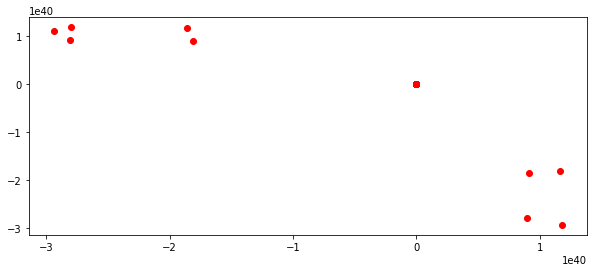

In [126]:
plt.figure(figsize=(10,4))

for t in range(0,tmax-1):
    plt.plot(x[t],x[t+1], 'ro')
plt.show(True)

### Networks

Let us adapt the logistic map to netowrks.

In [66]:
C, c_nm = hierarchical_connectivities([1,0,1],1,2)

tmax = 1000
x0 = 11
a = 2

In [67]:
G = nx.from_numpy_matrix(C)

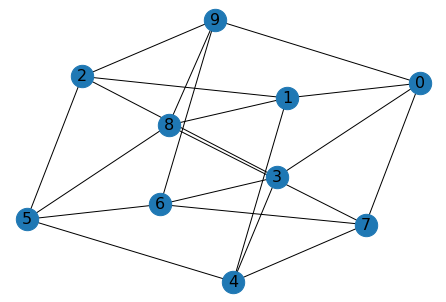

In [68]:
pos=nx.circular_layout(G)
nx.draw(G, with_labels = True, node_size=500, font_size=16)
plt.show(True)

In [69]:
tmax = 1000
N = len(G.nodes)
x = np.zeros((N,tmax))
M = len(G.edges)
sigma = 2
a = 3
x[:,0] = np.random.uniform(0,1,N)
for t in range(0,tmax-1):
    for i in G.nodes:
        x[i,t+1] = a*x[i,t]*(1-x[i,t])
        #for j in G.predecessors(i): #for directed networks
        for j in G.neighbors(i): # for undirected networks
            x[i,t+1] = x[i,t+1] + (sigma/M)*(a*x[j,t]*(1-x[j,t])-a*x[i,t]*(1-x[i,t]))

#print('Time series for each node:\n')
#for i in G.nodes:
#    #print('Node:', i,'Neig:', list(G.predecessors(i)))
#    print('Node:', i, ':', x[i,:],'\n')

# PCMCI

In [70]:
dataframe = pp.DataFrame(np.transpose(x))
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

results = pcmci.run_pcmci(tau_max=1, pc_alpha=None)

In [71]:
pq_matrix = results['p_matrix']

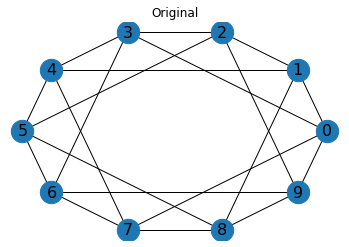

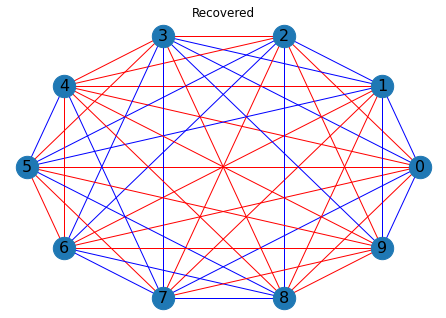

In [72]:
G = G.to_undirected()
plt.title('Original')
nx.draw(G, with_labels = True, node_size=500, font_size=16, pos = pos)
plt.show(True)


edges = []
color = []
# I need to fix this, colors are not rigth
M = pq_matrix.shape[0]
alpha = 0.01
for i in range(M):
    for j in range(M): 
        if pq_matrix[i,j,0] <= alpha and i!=j:
            edges.append((i,j))
            if(G.has_edge(i,j)):
                color.append('blue')
            else:
                color.append('red')

G2 = nx.Graph(edges)
nx.draw(G2, with_labels = True, node_size=500, font_size=16, pos = pos, edge_color = color)
plt.title('Recovered')
plt.show(True)

# CCM

In [51]:
x1 = x[0,:]
x2 = x[9,:]

In [53]:
df = pd.DataFrame({"x0":x1, "x1":x1,"x2":x2})

r = ed.EmbedDimension( dataFrame = df, lib = "10 1000", pred = "201 500", columns = "x1", target = "x1", showPlot=False) 

r["E"][r["rho"].iloc[1:].idxmax()]

3.0

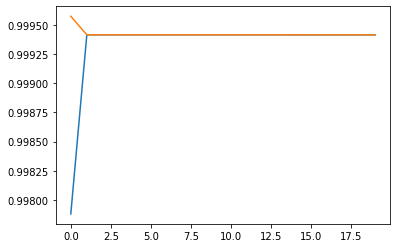

In [54]:
lag = 1
embed = 3
e1 = ccm.Embed(x1)
e2 = ccm.Embed(x2)
X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)

#split the embedded time series
x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

CCM = ccm.CCM() #initiate the class

#library lengths to test
len_tr = len(x1tr)
lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')
#lib_lens = [10,20]

#test causation
CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

sc1,sc2 = CCM.score()

plt.plot(np.arange(len(sc1)),sc1,np.arange(len(sc1)),sc2)

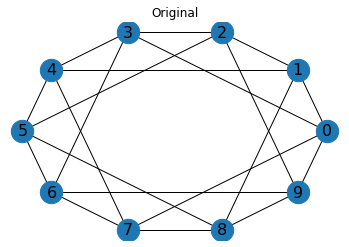

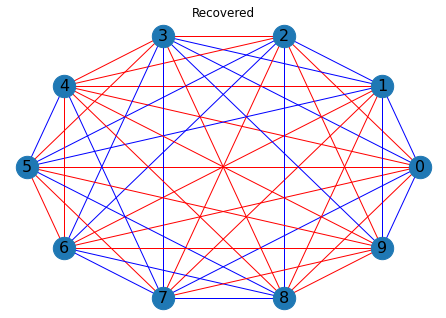

In [56]:
G = G.to_undirected()
plt.title('Original')
nx.draw(G, with_labels = True, node_size=500, font_size=16, pos = pos)
plt.show(True)


edges = []
color = []
# I need to fix this, colors are not rigth
M = x.shape[0]
for i in range(M):
    for j in range(M): 
        if i!=j and CCM_calculator(x[i,:],x[j,:]):
            edges.append((i,j))
            if(G.has_edge(i,j)):
                color.append('blue')
            else:
                color.append('red')

G2 = nx.Graph(edges)
nx.draw(G2, with_labels = True, node_size=500, font_size=16, pos = pos, edge_color = color)
plt.title('Recovered')
plt.show(True)

/home/mathsys2/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/mathsys2/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


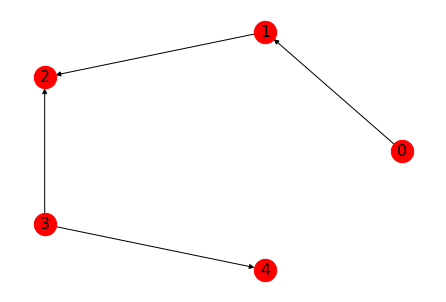

In [9]:


#N = 10
#av_degree = 1
#p = av_degree/(N-1)
#G = nx.gnp_random_graph(N, p, seed=None, directed=False)

#pos = nx.fruchterman_reingold_layout(G);
#plt.figure(figsize=(8,8));
#plt.axis("off");
#nx.draw_networkx_nodes(G, pos, node_size=300, node_color="black");
#nx.draw_networkx_edges(G, pos, alpha=0.500);
#nx.draw_networkx_labels(G, pos, font_color="white");
#plt.show();

edgelist=[(0,1),(1,2), (3,4),(3,2)]
G = nx.DiGraph(edgelist)
#G = nx.Graph(edgelist)
N = np.max(edgelist)

pos=nx.circular_layout(G)
nx.draw(G, with_labels = True, node_size=500, font_size=16, pos = pos)
plt.show(True)

In [4]:
tmax = 20
N = len(G.nodes)
x = np.zeros((N,tmax))
M = len(G.edges)
sigma = 3
a = 3.8
x[:,0] = np.random.uniform(0,1,N)
for t in range(0,tmax-1):
    for i in G.nodes:
        x[i,t+1] = a*x[i,t]*(1-x[i,t])
        for j in G.predecessors(i): #for directed networks
        #for j in G.neighbors(i): # for undirected networks
            x[i,t+1] = x[i,t+1] + (sigma/M)*(a*x[j,t]*(1-x[j,t])-a*x[i,t]*(1-x[i,t]))

print('Time series for each node:\n')
for i in G.nodes:
    #print('Node:', i,'Neig:', list(G.predecessors(i)))
    print('Node:', i, ':', x[i,:],'\n')

Time series for each node:

Node: 0 : [0.68027373 0.82650526 0.54489841 0.9423397  0.20647522 0.62260418
 0.89287921 0.36345451 0.87915025 0.40373133 0.9147829  0.29622955
 0.79221489 0.62551975 0.89013021 0.37163398 0.88738423 0.37974715
 0.89504916 0.35695741] 

Node: 1 : [0.93582747 0.67693064 0.61643458 0.93137562 0.21557574 0.62760084
 0.89169153 0.36433974 0.87937917 0.40356637 0.9147527  0.29625334
 0.7922241  0.62551463 0.89013143 0.37163308 0.88738401 0.37974731
 0.8950492  0.35695738] 

Node: 2 : [0.64749738 0.14995501 1.08648063 1.01182579 0.68196471 0.72956621
 0.59301915 0.50203175 0.40956525 0.44059356 0.67880425 0.48292608
 0.37643206 0.66471544 0.59658894 0.53136961 0.33656892 0.30307532
 0.95937176 0.40532103] 

Node: 3 : [0.82446203 0.54995268 0.94051797 0.21258687 0.63609604 0.87961589
 0.40238873 0.91379376 0.29934397 0.79700119 0.61480311 0.89991694
 0.34225249 0.85543974 0.46991784 0.94656124 0.19221562 0.59002134
 0.9192054  0.28221397] 

Node: 4 : [0.2230096  0.

### Correlation

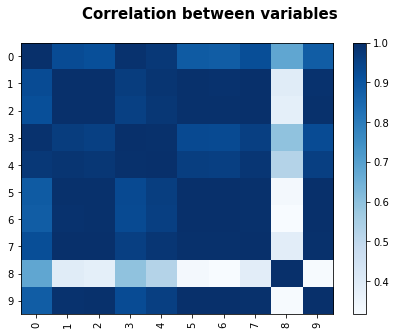

In [143]:
import pandas as pd # biblioteca pandas
data = pd.DataFrame(data=x.T)

corr = data.corr()
plt.figure(figsize=(7, 5))
plt.imshow(corr, cmap='Blues', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr)), corr.columns);
plt.suptitle('Correlation between variables', fontsize=15, fontweight='bold')
plt.grid(False)
plt.show()

In [144]:
corr

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.927008,0.917857,0.993221,0.977616,0.886984,0.881792,0.921469,0.681868,0.880859
1,0.927008,1.000000,0.999632,0.963339,0.984598,0.994674,0.993751,0.999788,0.393546,0.993169
2,0.917857,0.999632,1.000000,0.956386,0.979863,0.997080,0.996348,0.999956,0.378138,0.995939
3,0.993221,0.963339,0.956386,1.000000,0.995330,0.932153,0.928315,0.958970,0.596167,0.927208
4,0.977616,0.984598,0.979863,0.995330,1.000000,0.962108,0.959332,0.981576,0.524676,0.958317
5,0.886984,0.994674,0.997080,0.932153,0.962108,1.000000,0.999915,0.996432,0.327817,0.999906
6,0.881792,0.993751,0.996348,0.928315,0.959332,0.999915,1.000000,0.995587,0.315702,0.999939
7,0.921469,0.999788,0.999956,0.958970,0.981576,0.996432,0.995587,1.000000,0.386569,0.995183
8,0.681868,0.393546,0.378138,0.596167,0.524676,0.327817,0.315702,0.386569,1.000000,0.318419
9,0.880859,0.993169,0.995939,0.927208,0.958317,0.999906,0.999939,0.995183,0.318419,1.000000


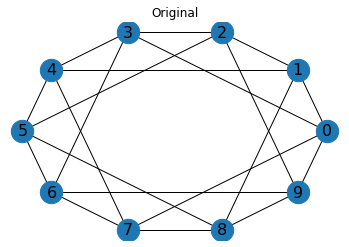

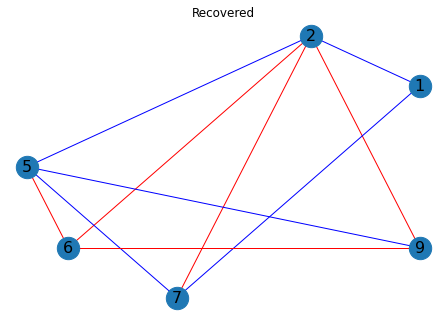

In [145]:
G = G.to_undirected()
plt.title('Original')
nx.draw(G, with_labels = True, node_size=500, font_size=16, pos = pos)
plt.show(True)

corr = np.array(corr)
for i in range(corr.shape[0]):
    corr[i,i] = -np.inf
edges = []
color = []
# I need to fix this, colors are not rigth
for m in range(0,M):
    i,j = np.where(corr == np.max(corr))
    corr[i,j] = -np.inf
    edges.append((i[0],j[0]))
    if(G.has_edge(i[0],j[0])):
        color.append('blue')
    else:
        color.append('red')

G2 = nx.Graph(edges)
nx.draw(G2, with_labels = True, node_size=500, font_size=16, pos = pos, edge_color = color)
plt.title('Recovered')
plt.show(True)